<a href="https://colab.research.google.com/github/ayomibamm/Disease-Classification/blob/main/Disease_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **THYROID DISEASE PREDICTION**

In [101]:
# Import libaries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from statistics import mean, stdev
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,roc_auc_score, roc_curve
from sklearn.multiclass import OneVsRestClassifier
from sklearn.datasets import make_classification
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Conv1D, Flatten, Dense, Dropout
from keras.optimizers import Adam

# **DATA UNDERSTANDING & PREPARATION**
 General overview of the dataset, including the statistical summary.

In [2]:
# load dataset
thyroid_df = pd.read_csv("thyroid_df.csv")

In [3]:
# The first 5 rows of the data
thyroid_df.head(5)

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_meds,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,TT4,T4U_measured,T4U,FTI_measured,FTI,TBG_measured,TBG,referral_source,target,patient_id
0,29,F,f,f,f,f,f,f,f,t,...,NaN,f,NaN,f,NaN,f,NaN,other,-,840801013
1,29,F,f,f,f,f,f,f,f,f,...,128.0,f,NaN,f,NaN,f,NaN,other,-,840801014
2,41,F,f,f,f,f,f,f,f,f,...,NaN,f,NaN,f,NaN,t,11.0,other,-,840801042
3,36,F,f,f,f,f,f,f,f,f,...,NaN,f,NaN,f,NaN,t,26.0,other,-,840803046
4,32,F,f,f,f,f,f,f,f,f,...,NaN,f,NaN,f,NaN,t,36.0,other,S,840803047


In [4]:
# the number of rows and columns
thyroid_df.shape

(9172, 31)

In [5]:
# list of column names
thyroid_df.columns

Index(['age', 'sex', 'on_thyroxine', 'query_on_thyroxine',
       'on_antithyroid_meds', 'sick', 'pregnant', 'thyroid_surgery',
       'I131_treatment', 'query_hypothyroid', 'query_hyperthyroid', 'lithium',
       'goitre', 'tumor', 'hypopituitary', 'psych', 'TSH_measured', 'TSH',
       'T3_measured', 'T3', 'TT4_measured', 'TT4', 'T4U_measured', 'T4U',
       'FTI_measured', 'FTI', 'TBG_measured', 'TBG', 'referral_source',
       'target', 'patient_id'],
      dtype='object')

In [6]:
# remove unnecessary columns as suggested by originator.
thyroid_df.drop(['patient_id', 'referral_source'], axis=1, inplace=True)

# review after changes
thyroid_df.head(5)

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_meds,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,T3,TT4_measured,TT4,T4U_measured,T4U,FTI_measured,FTI,TBG_measured,TBG,target
0,29,F,f,f,f,f,f,f,f,t,...,NaN,f,NaN,f,NaN,f,NaN,f,NaN,-
1,29,F,f,f,f,f,f,f,f,f,...,1.9,t,128.0,f,NaN,f,NaN,f,NaN,-
2,41,F,f,f,f,f,f,f,f,f,...,NaN,f,NaN,f,NaN,f,NaN,t,11.0,-
3,36,F,f,f,f,f,f,f,f,f,...,NaN,f,NaN,f,NaN,f,NaN,t,26.0,-
4,32,F,f,f,f,f,f,f,f,f,...,NaN,f,NaN,f,NaN,f,NaN,t,36.0,S


In [7]:
# checking data type of the columns
thyroid_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9172 entries, 0 to 9171
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  9172 non-null   int64  
 1   sex                  8865 non-null   object 
 2   on_thyroxine         9172 non-null   object 
 3   query_on_thyroxine   9172 non-null   object 
 4   on_antithyroid_meds  9172 non-null   object 
 5   sick                 9172 non-null   object 
 6   pregnant             9172 non-null   object 
 7   thyroid_surgery      9172 non-null   object 
 8   I131_treatment       9172 non-null   object 
 9   query_hypothyroid    9172 non-null   object 
 10  query_hyperthyroid   9172 non-null   object 
 11  lithium              9172 non-null   object 
 12  goitre               9172 non-null   object 
 13  tumor                9172 non-null   object 
 14  hypopituitary        9172 non-null   object 
 15  psych                9172 non-null   o

In [8]:
# statistical summary of dataset
thyroid_df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
age,9172.0,NaN,NaN,NaN,73.555822,1183.976718,1.0,37.0,55.0,68.0,65526.0
sex,8865,2,F,6073,NaN,NaN,NaN,NaN,NaN,NaN,NaN
on_thyroxine,9172,2,f,7932,NaN,NaN,NaN,NaN,NaN,NaN,NaN
query_on_thyroxine,9172,2,f,9019,NaN,NaN,NaN,NaN,NaN,NaN,NaN
on_antithyroid_meds,9172,2,f,9056,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sick,9172,2,f,8828,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pregnant,9172,2,f,9065,NaN,NaN,NaN,NaN,NaN,NaN,NaN
thyroid_surgery,9172,2,f,9038,NaN,NaN,NaN,NaN,NaN,NaN,NaN
I131_treatment,9172,2,f,9003,NaN,NaN,NaN,NaN,NaN,NaN,NaN
query_hypothyroid,9172,2,f,8542,NaN,NaN,NaN,NaN,NaN,NaN,NaN


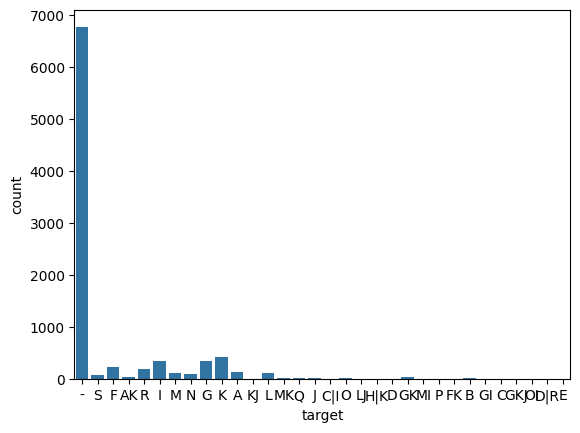

In [9]:
# count of the unique target variable, as well as graphical representation
thyroid_df.target.value_counts()
sns.countplot(x ='target', data = thyroid_df)
plt.show()

In [10]:
# investigate and display duplicated rows
print(thyroid_df[thyroid_df.duplicated()])

# drop duplicates and review shape
thyroid_df.drop_duplicates(inplace=True)

thyroid_df.shape

      age  sex on_thyroxine query_on_thyroxine on_antithyroid_meds sick  \
98     60    F            t                  f                   f    f   
1239   68    F            f                  f                   f    f   
2160   32    F            f                  f                   f    f   
2211   57    F            f                  f                   f    f   
2348   65    F            f                  f                   f    f   
2716   26    F            f                  f                   f    f   
4195   63  NaN            f                  f                   f    f   
4781   71    F            f                  f                   f    f   
5282   40    F            f                  f                   f    f   
5307   21    F            f                  f                   f    f   

     pregnant thyroid_surgery I131_treatment query_hypothyroid  ...   T3  \
98          f               f              f                 t  ...  1.8   
1239        f         

(9162, 29)

# **FEATURE ENGINEERING**
Visualization of missing values, creation of new target class, encoding the categorical variables, Imputing missing values.

<Axes: >

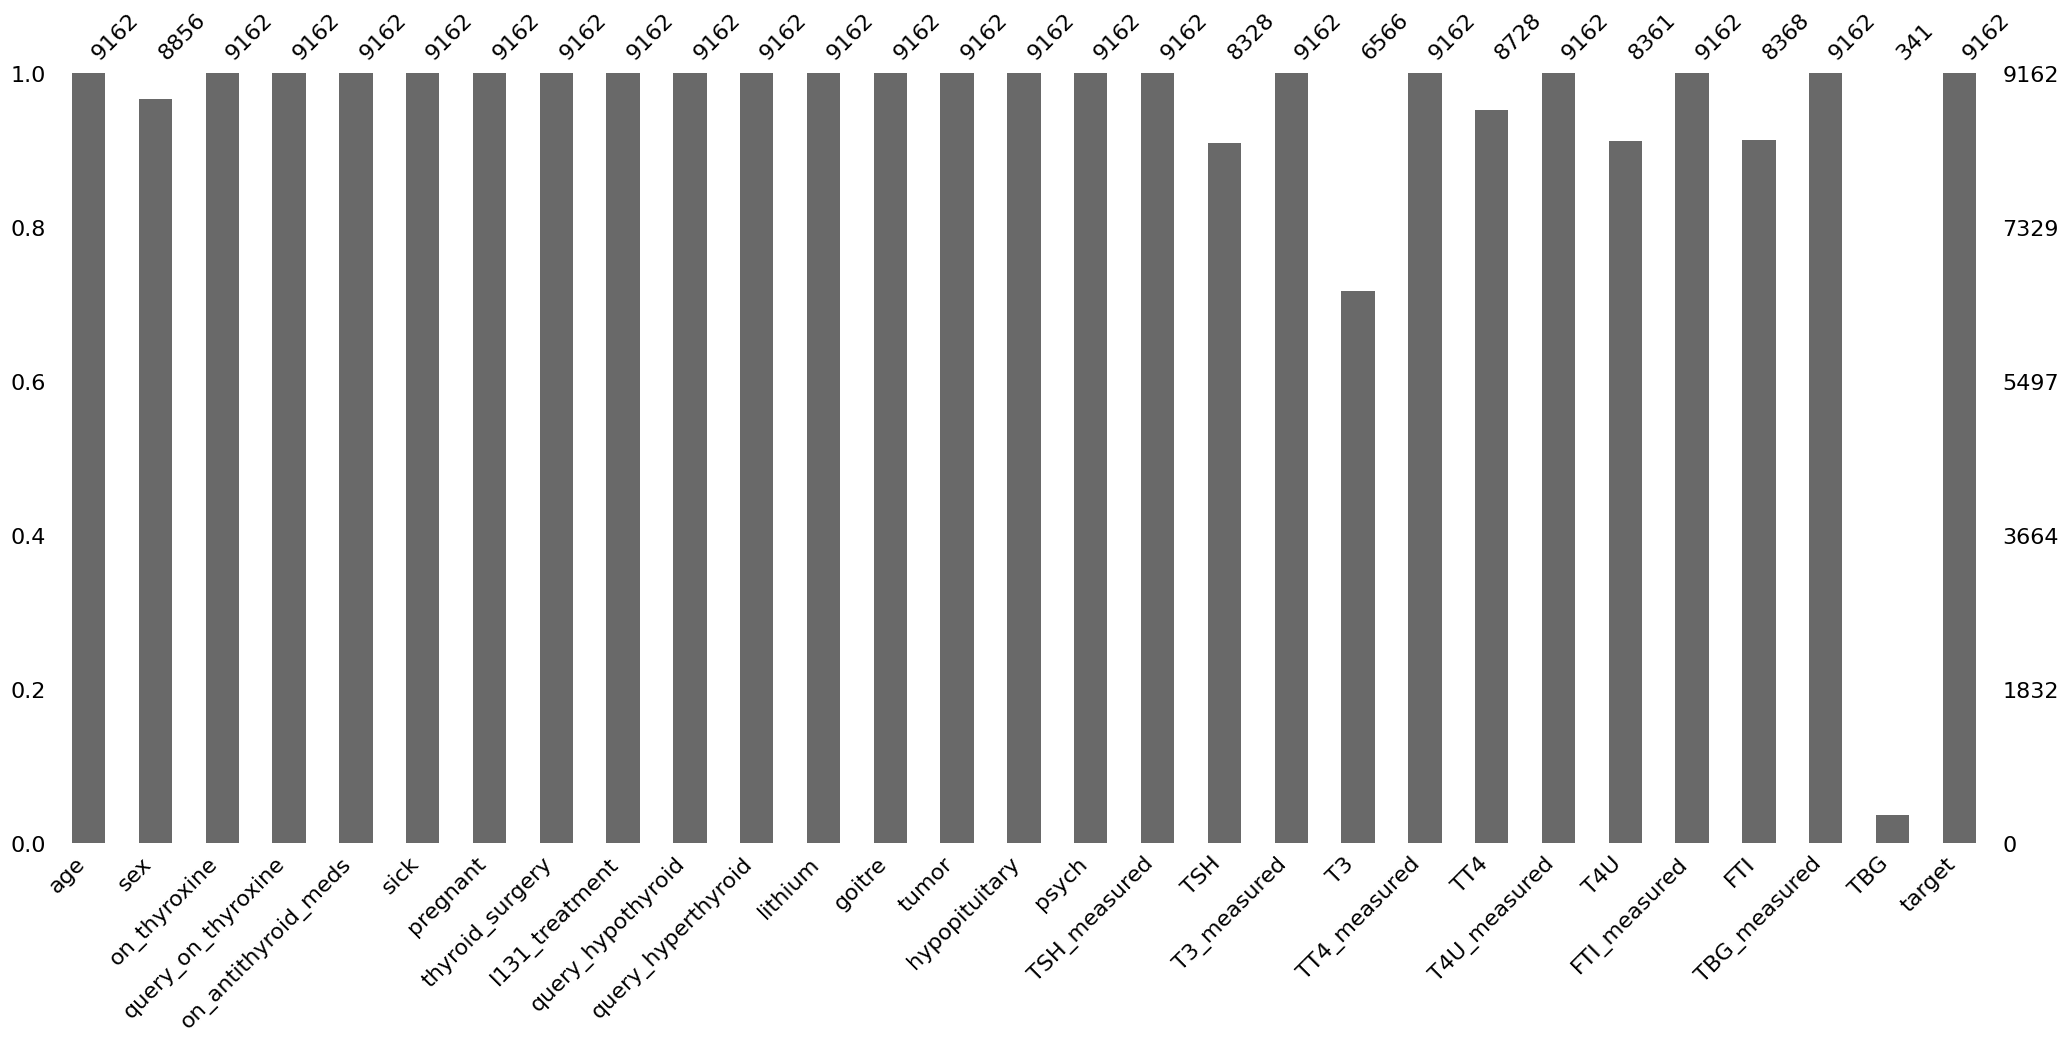

In [11]:
# visualization of missing values

msno.bar(thyroid_df)

In [12]:
# remove column TBG as missing value > threshold of 50%
thyroid_df.drop('TBG', axis=1, inplace=True)
thyroid_df.shape

(9162, 28)

In [13]:
columns_to_check = ['T3', 'FTI', 'TSH', 'T4U', 'sex']

for column in columns_to_check:
    missing_df = thyroid_df[thyroid_df[column].isnull()]
    print(f"Missing values in {column} column for normal class:")
    print(missing_df[missing_df['target'] == '-']['target'].value_counts())
    thyroid_df = thyroid_df.loc[~((thyroid_df[column].isnull()) & (thyroid_df['target'] == '-'))]

print("Shape after removing rows with missing values:", thyroid_df.shape)

Missing values in T3 column for normal class:
target
-    2003
Name: count, dtype: int64
Missing values in FTI column for normal class:
target
-    342
Name: count, dtype: int64
Missing values in TSH column for normal class:
target
-    116
Name: count, dtype: int64
Missing values in T4U column for normal class:
target
-    6
Name: count, dtype: int64
Missing values in sex column for normal class:
target
-    128
Name: count, dtype: int64
Shape after removing rows with missing values: (6567, 28)


In [14]:
# count by gender
print(thyroid_df.sex.value_counts())

# as NAN is present in this categorical variable, KNN imputer creates a new category for it
## therefore, will be filled with mode- most frequent value in the column
thyroid_df['sex'] =  thyroid_df['sex'].fillna('F')

# map the sex
thyroid_df['sex'] = thyroid_df['sex'].map({'F' : 0, 'M' : 1})
thyroid_df.sex.value_counts()

sex
F    4418
M    2054
Name: count, dtype: int64


sex
0    4513
1    2054
Name: count, dtype: int64

In [15]:
# confirm that there are no missing values
thyroid_df['sex'].isna().sum()

0

In [16]:
#counting unique values in each column
thyroid_df.nunique(axis=0)

age                     98
sex                      2
on_thyroxine             2
query_on_thyroxine       2
on_antithyroid_meds      2
sick                     2
pregnant                 2
thyroid_surgery          2
I131_treatment           2
query_hypothyroid        2
query_hyperthyroid       2
lithium                  2
goitre                   2
tumor                    2
hypopituitary            2
psych                    2
TSH_measured             2
TSH                    364
T3_measured              2
T3                      83
TT4_measured             2
TT4                    287
T4U_measured             2
T4U                    175
FTI_measured             2
FTI                    323
TBG_measured             2
target                  32
dtype: int64

In [17]:
#Target varible unique value count
thyroid_df.target.value_counts()

target
-      4168
K       436
G       359
I       346
F       233
R       196
A       147
L       115
M       111
N       110
S        83
GK       49
AK       46
J        30
B        21
MK       16
Q        14
O        14
C|I      12
KJ       11
GI       10
H|K       8
D         8
FK        6
C         6
P         5
MI        2
LJ        1
GKJ       1
OI        1
D|R       1
E         1
Name: count, dtype: int64

In [18]:
# Define the replacement mappings
target_mapping = {
    'B': 'A', 'C': 'A', 'D': 'A',    # HYPERTHYROIDISM GROUP
    'E': 'B', 'F': 'B', 'G': 'B', 'H': 'B',    # HYPOTHYROIDISM GROUP
    'I': 'C', 'J': 'C',    # BINDING PROTEIN
    'K': 'D',    # GENERAL HEALTH
    '-': 'E',    # NORMAL CLASS
    'L': 'F', 'M': 'F', 'N': 'F', 'O': 'F', 'P': 'F',    # MISCELLENEOUS
    'Q': 'F', 'R': 'F', 'S': 'F', 'T': 'F',    # MISCELLENEOUS
    'GK': 'G', 'AK': 'G', 'MK': 'G', 'C|I': 'G', 'KJ': 'G',    # UNCONFIRMED DIAGNOSIS
    'GI': 'G', 'H|K': 'G', 'FK': 'G', 'MI': 'G', 'LJ': 'G',    # UNCONFIRMED DIAGNOSIS
    'GKJ': 'G', 'OI': 'G', 'D|R': 'G'    # UNCONFIRMED DIAGNOSIS
}

# Replace target values using the mapping
thyroid_df['target'] = thyroid_df['target'].replace(target_mapping)


In [19]:
# count of the newly created target class
thyroid_df.target.value_counts()

target
E    4168
F     648
B     593
D     436
C     376
A     182
G     164
Name: count, dtype: int64

In [20]:
 # change categorical values to numerical values
label = LabelEncoder()

# select required variables- objects
cols = thyroid_df.select_dtypes(include=['object'])

# Transform variables
for col in cols.columns:
    thyroid_df[col] = label.fit_transform(thyroid_df[col])

In [21]:
# confirm data type
thyroid_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6567 entries, 4 to 9169
Data columns (total 28 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  6567 non-null   int64  
 1   sex                  6567 non-null   int64  
 2   on_thyroxine         6567 non-null   int64  
 3   query_on_thyroxine   6567 non-null   int64  
 4   on_antithyroid_meds  6567 non-null   int64  
 5   sick                 6567 non-null   int64  
 6   pregnant             6567 non-null   int64  
 7   thyroid_surgery      6567 non-null   int64  
 8   I131_treatment       6567 non-null   int64  
 9   query_hypothyroid    6567 non-null   int64  
 10  query_hyperthyroid   6567 non-null   int64  
 11  lithium              6567 non-null   int64  
 12  goitre               6567 non-null   int64  
 13  tumor                6567 non-null   int64  
 14  hypopituitary        6567 non-null   int64  
 15  psych                6567 non-null   int64 

<Axes: >

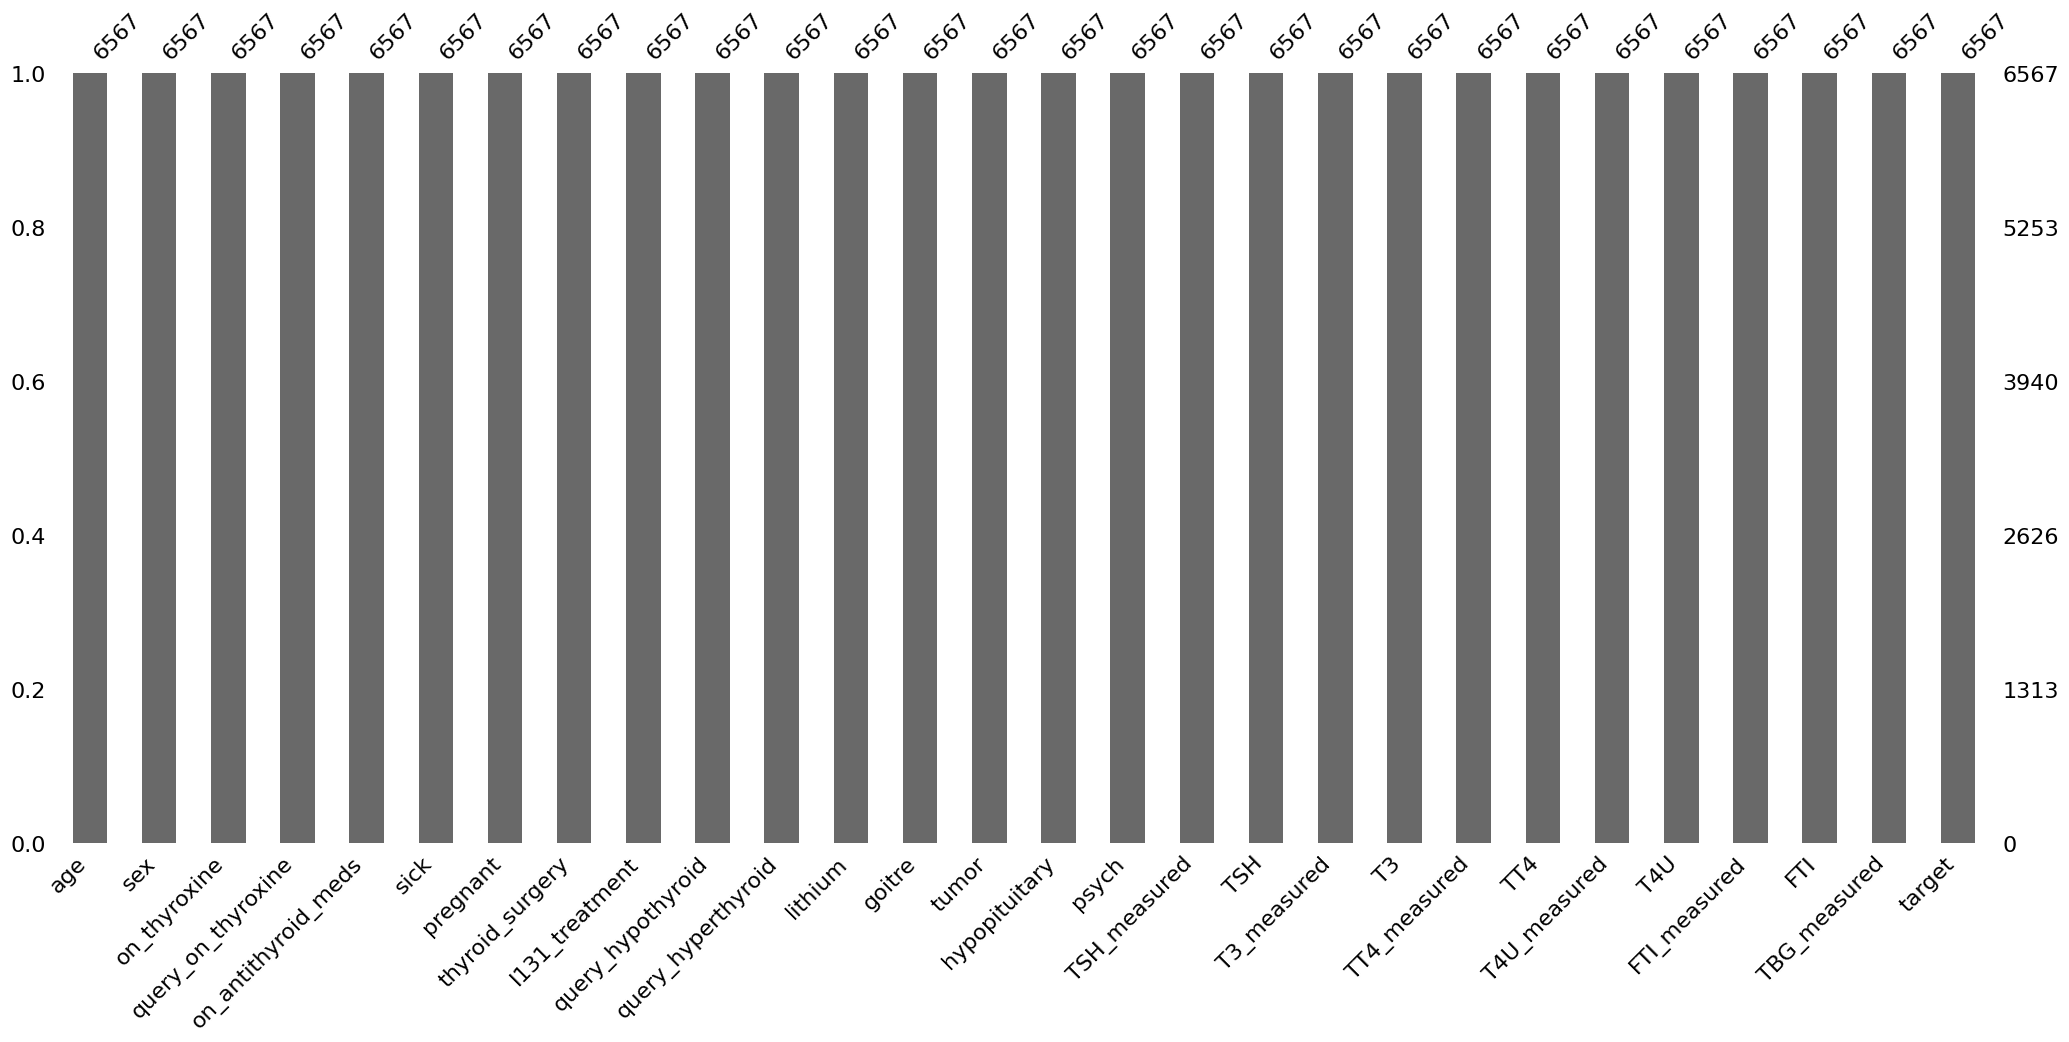

In [22]:
# Imputing missing values

imputer = KNNImputer(n_neighbors=3)
cols = ['TSH', 'T3', 'TT4', 'T4U', 'FTI']

for col in cols:
    thyroid_df[col] = imputer.fit_transform(thyroid_df[[col]])

# Visualization
msno.bar(thyroid_df)

In [23]:
#confirmation
thyroid_df.tail(5)

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_meds,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,T3_measured,T3,TT4_measured,TT4,T4U_measured,T4U,FTI_measured,FTI,TBG_measured,target
9153,64,1,0,0,0,0,0,0,0,0,...,0,1.95847,1,31.0,1,0.55,1,56.0,0,3
9157,60,1,0,0,1,0,0,0,0,0,...,0,1.95847,1,28.0,1,0.87,1,32.0,0,3
9158,64,1,0,0,0,0,0,0,0,1,...,0,1.95847,1,44.0,1,0.53,1,83.0,0,2
9162,36,0,0,0,0,0,0,0,0,0,...,0,1.95847,1,84.0,1,1.26,1,67.0,0,2
9169,69,1,0,0,0,0,0,0,0,0,...,0,1.95847,1,113.0,1,1.27,1,89.0,0,2


In [24]:
# drop new target class F and G (5, 6)
values = [5, 6]

#drop rows that contain any value in the list
thyroid_df = thyroid_df[thyroid_df.target.isin(values) == False]

thyroid_df.target.value_counts()

target
4    4168
1     593
3     436
2     376
0     182
Name: count, dtype: int64

In [25]:
thyroid_df.shape

(5755, 28)

# **EXPLORATORY DATA ANALYSIS**


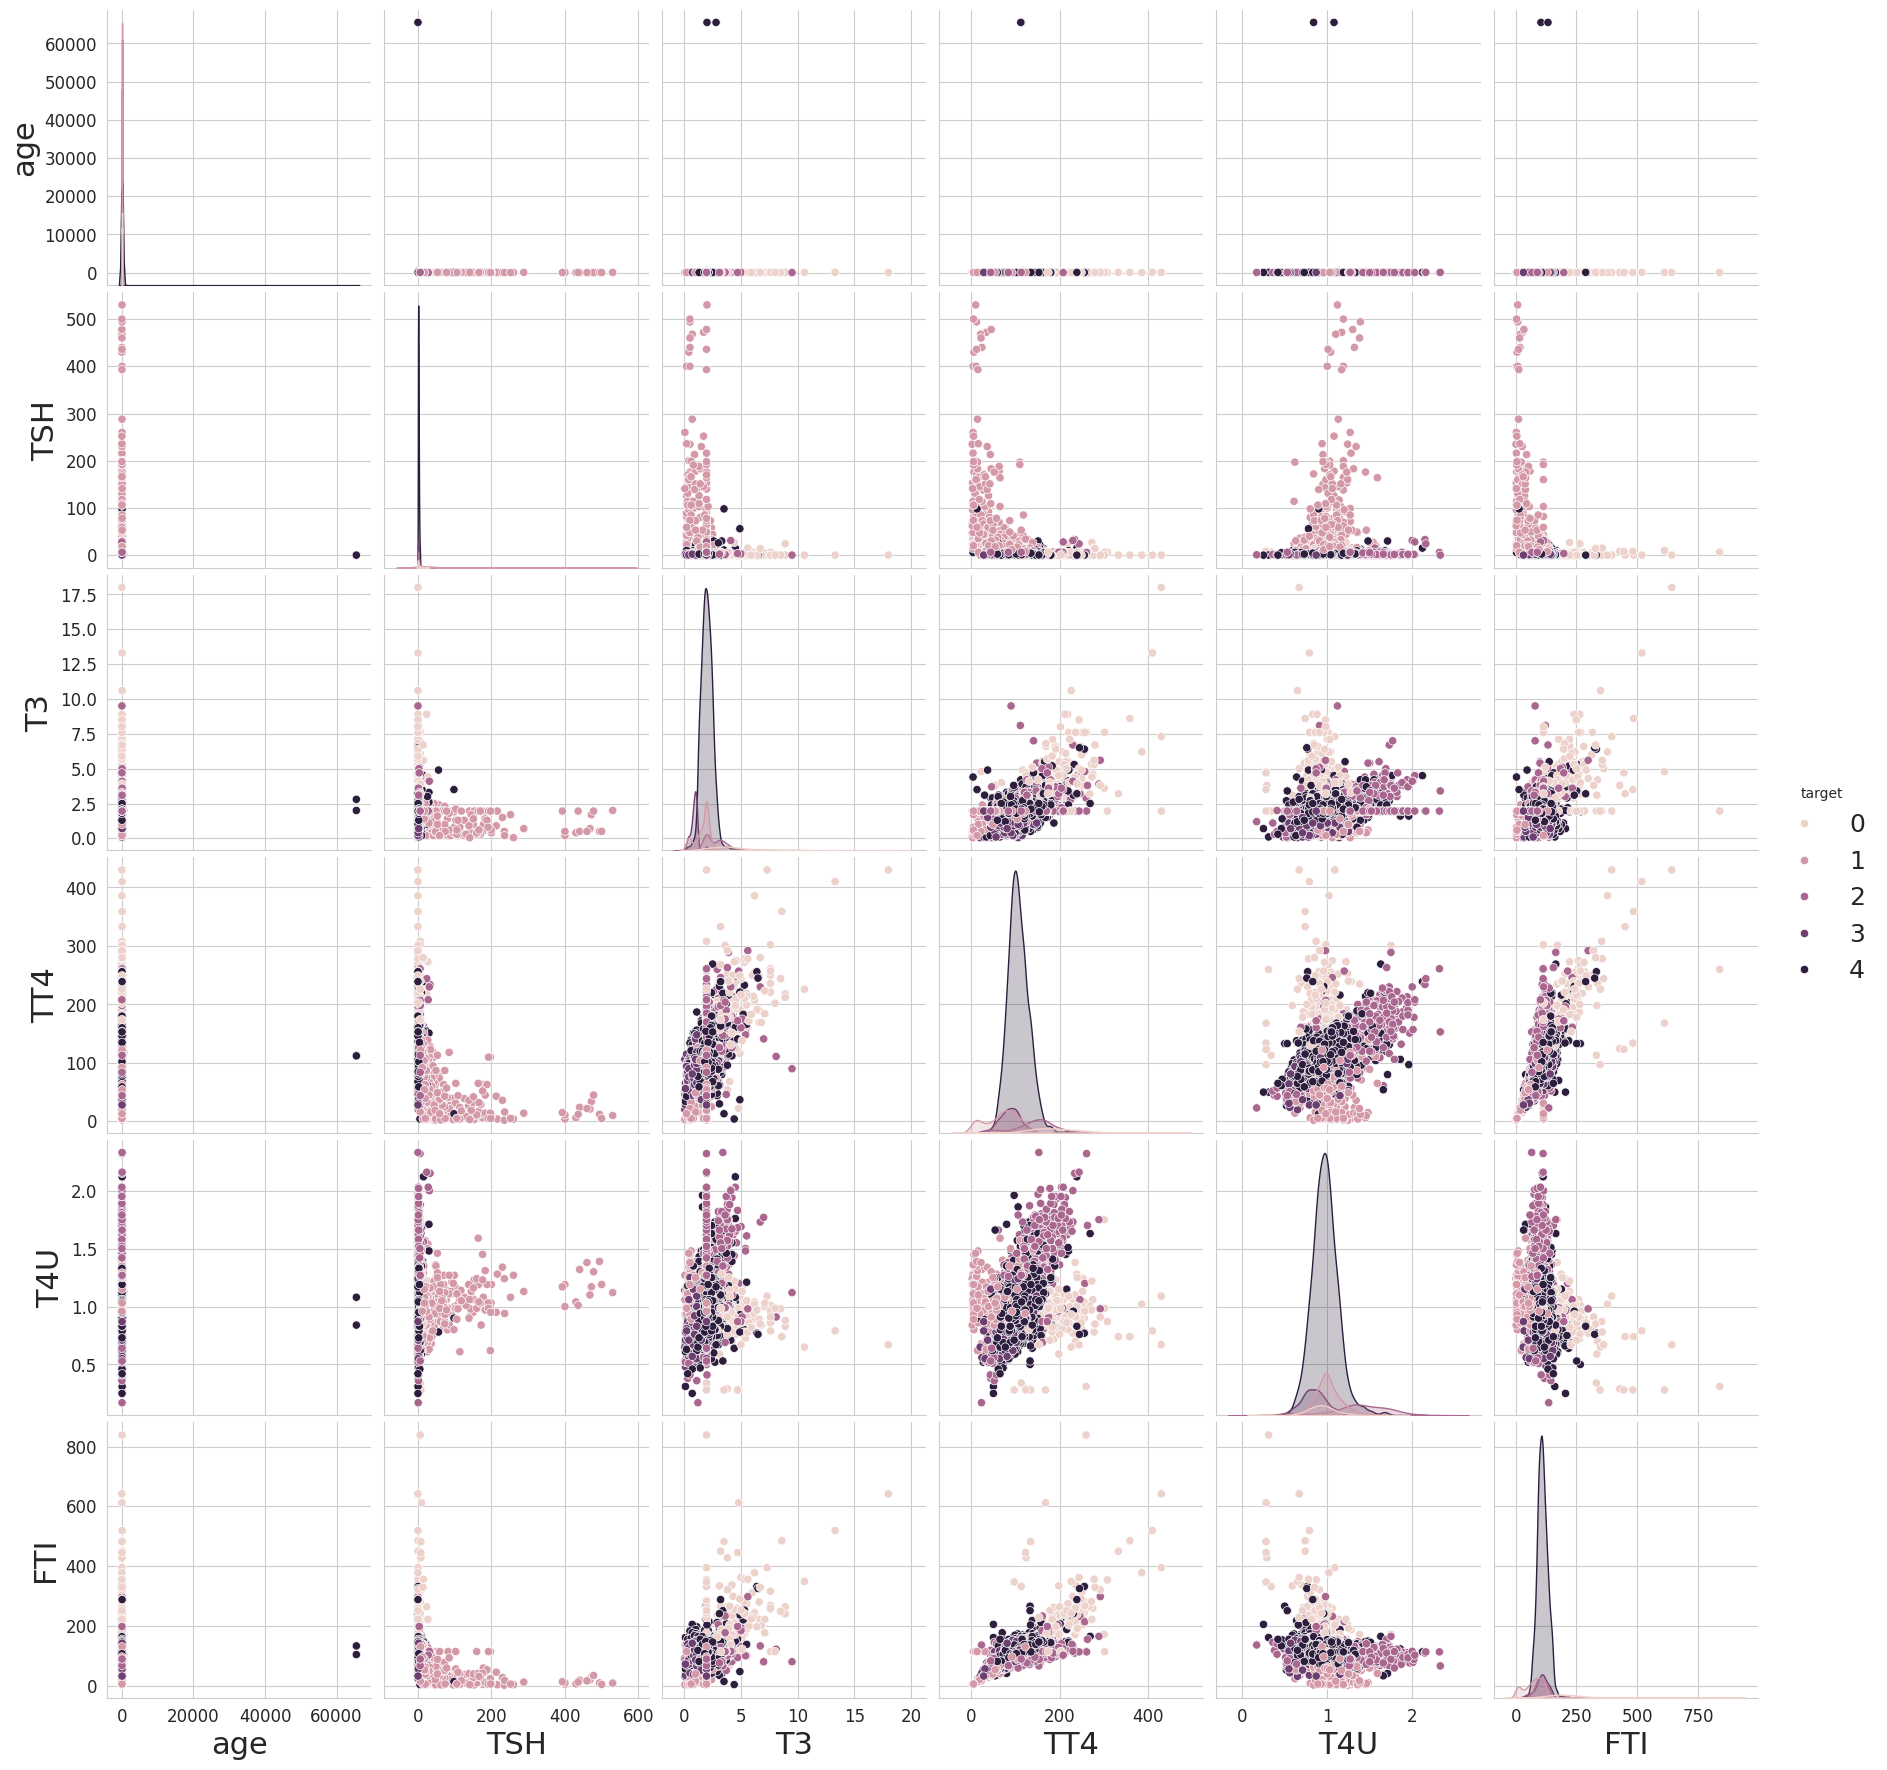

In [26]:
# Pairplot analysis
variables = thyroid_df[['age', 'TSH', 'T3', 'TT4', 'T4U', 'FTI', 'target']].copy()
sns.set_style('whitegrid');
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rc('legend', fontsize=18)
plt.rc('axes', labelsize=22)
sns.pairplot(variables, hue='target', height=3);
plt.show()

<Axes: >

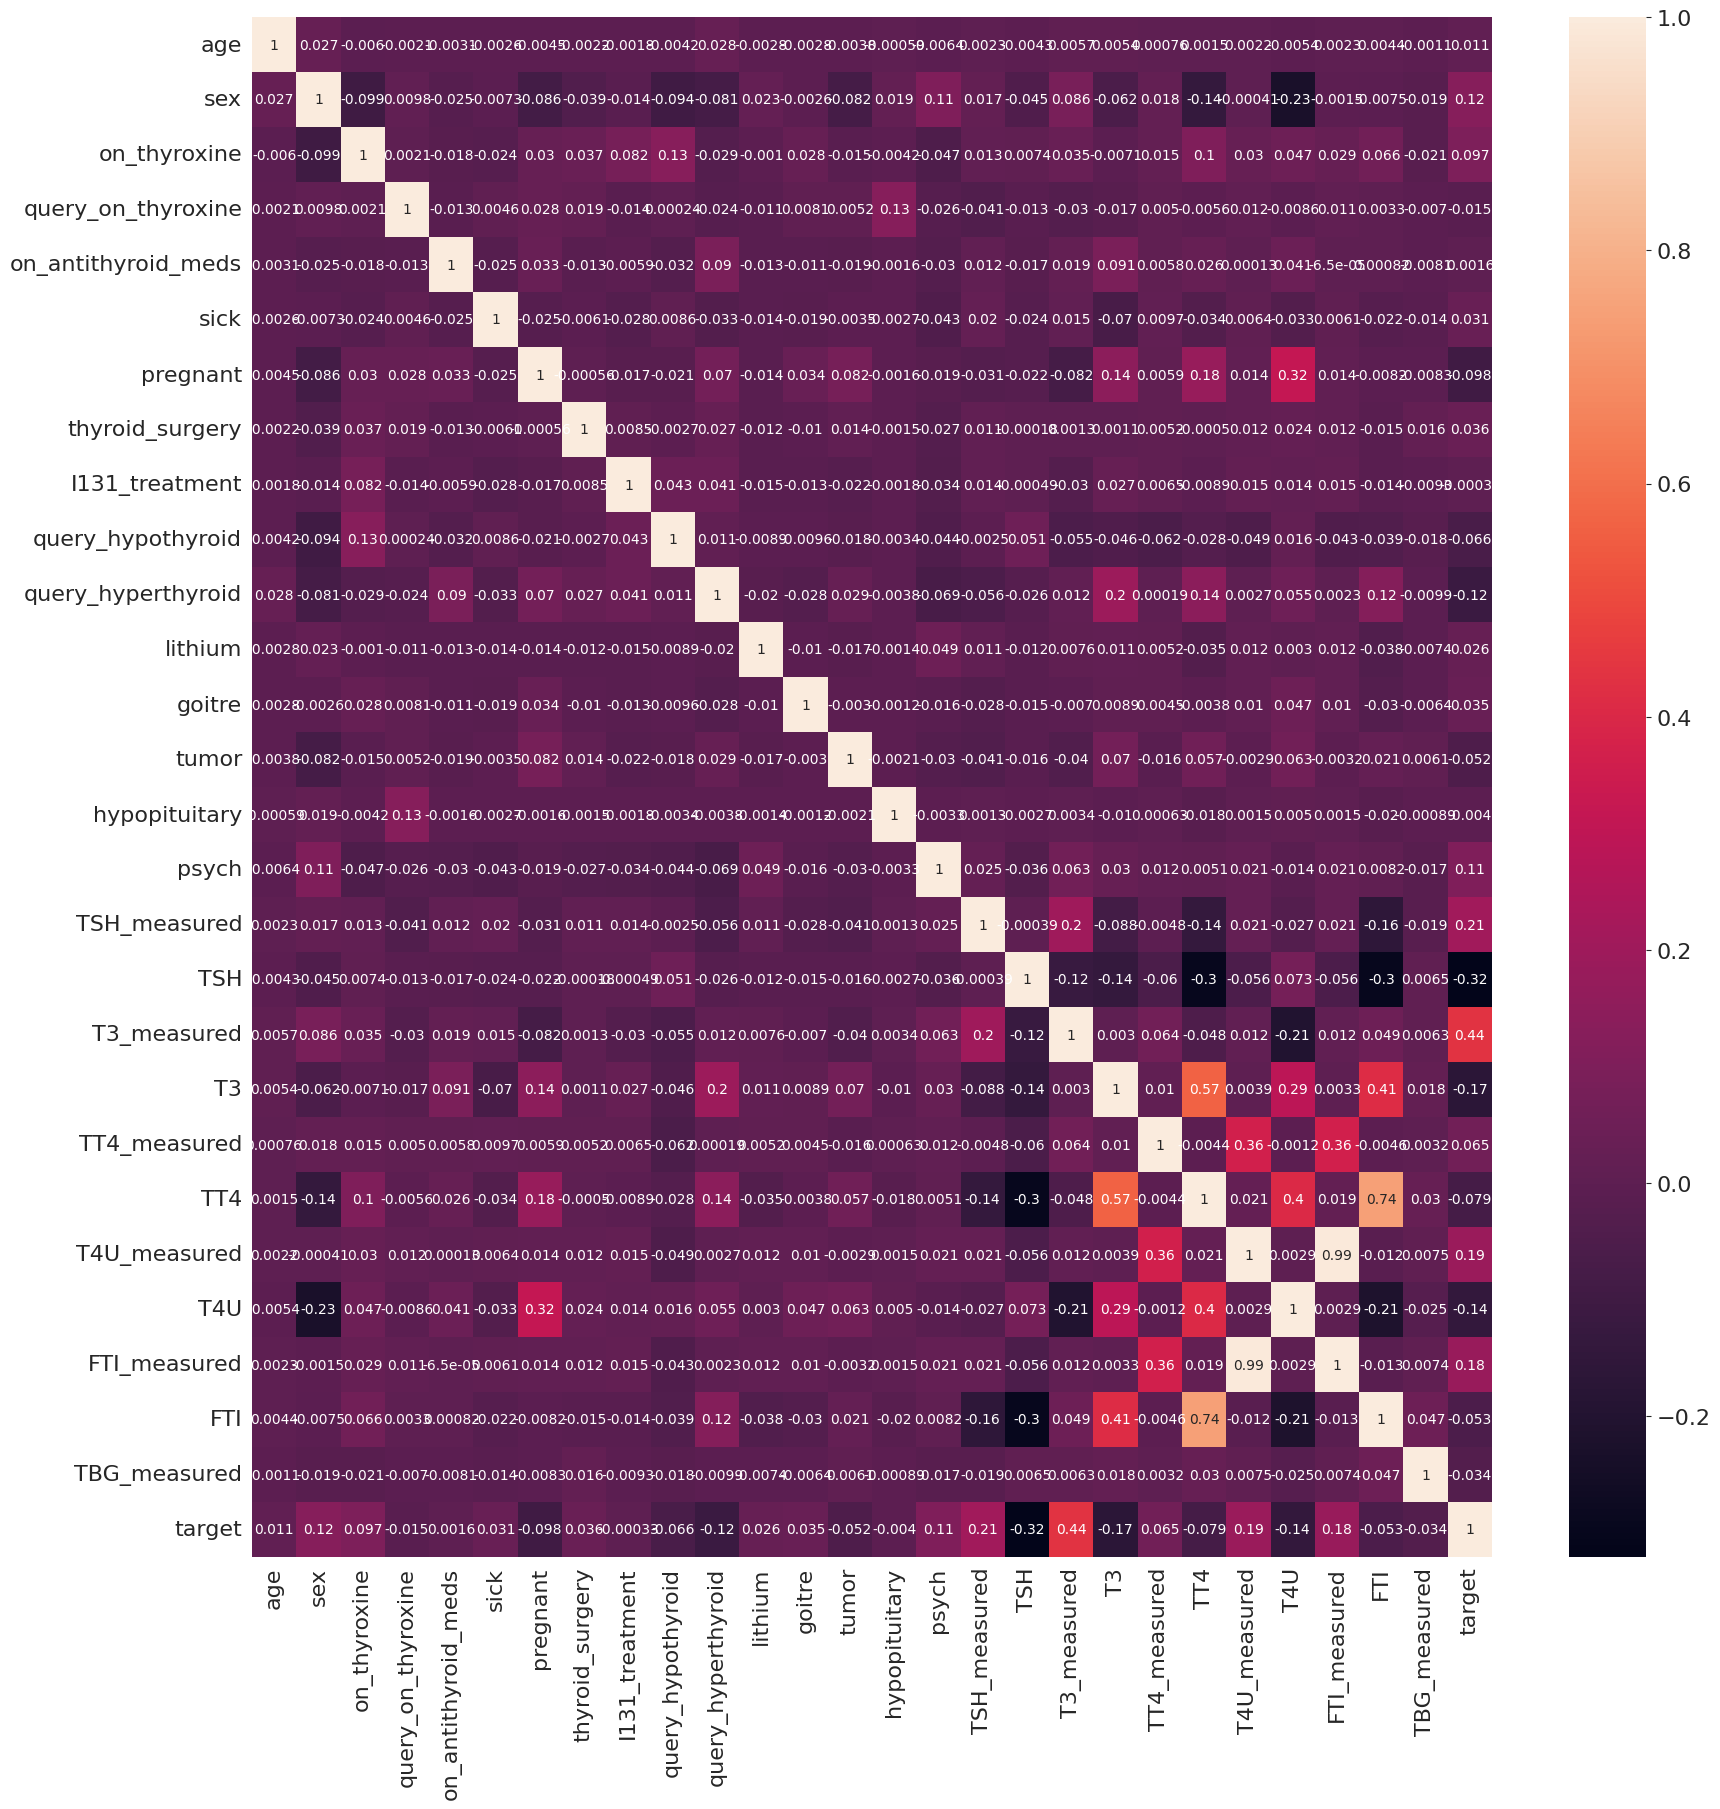

In [27]:
# correlation analysis
correlation = thyroid_df.corr(method = 'pearson')

# correlation matrix
plt.figure(figsize=(20,20))
plt.rc('font', size=10)
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
sns.heatmap(correlation, annot=True)

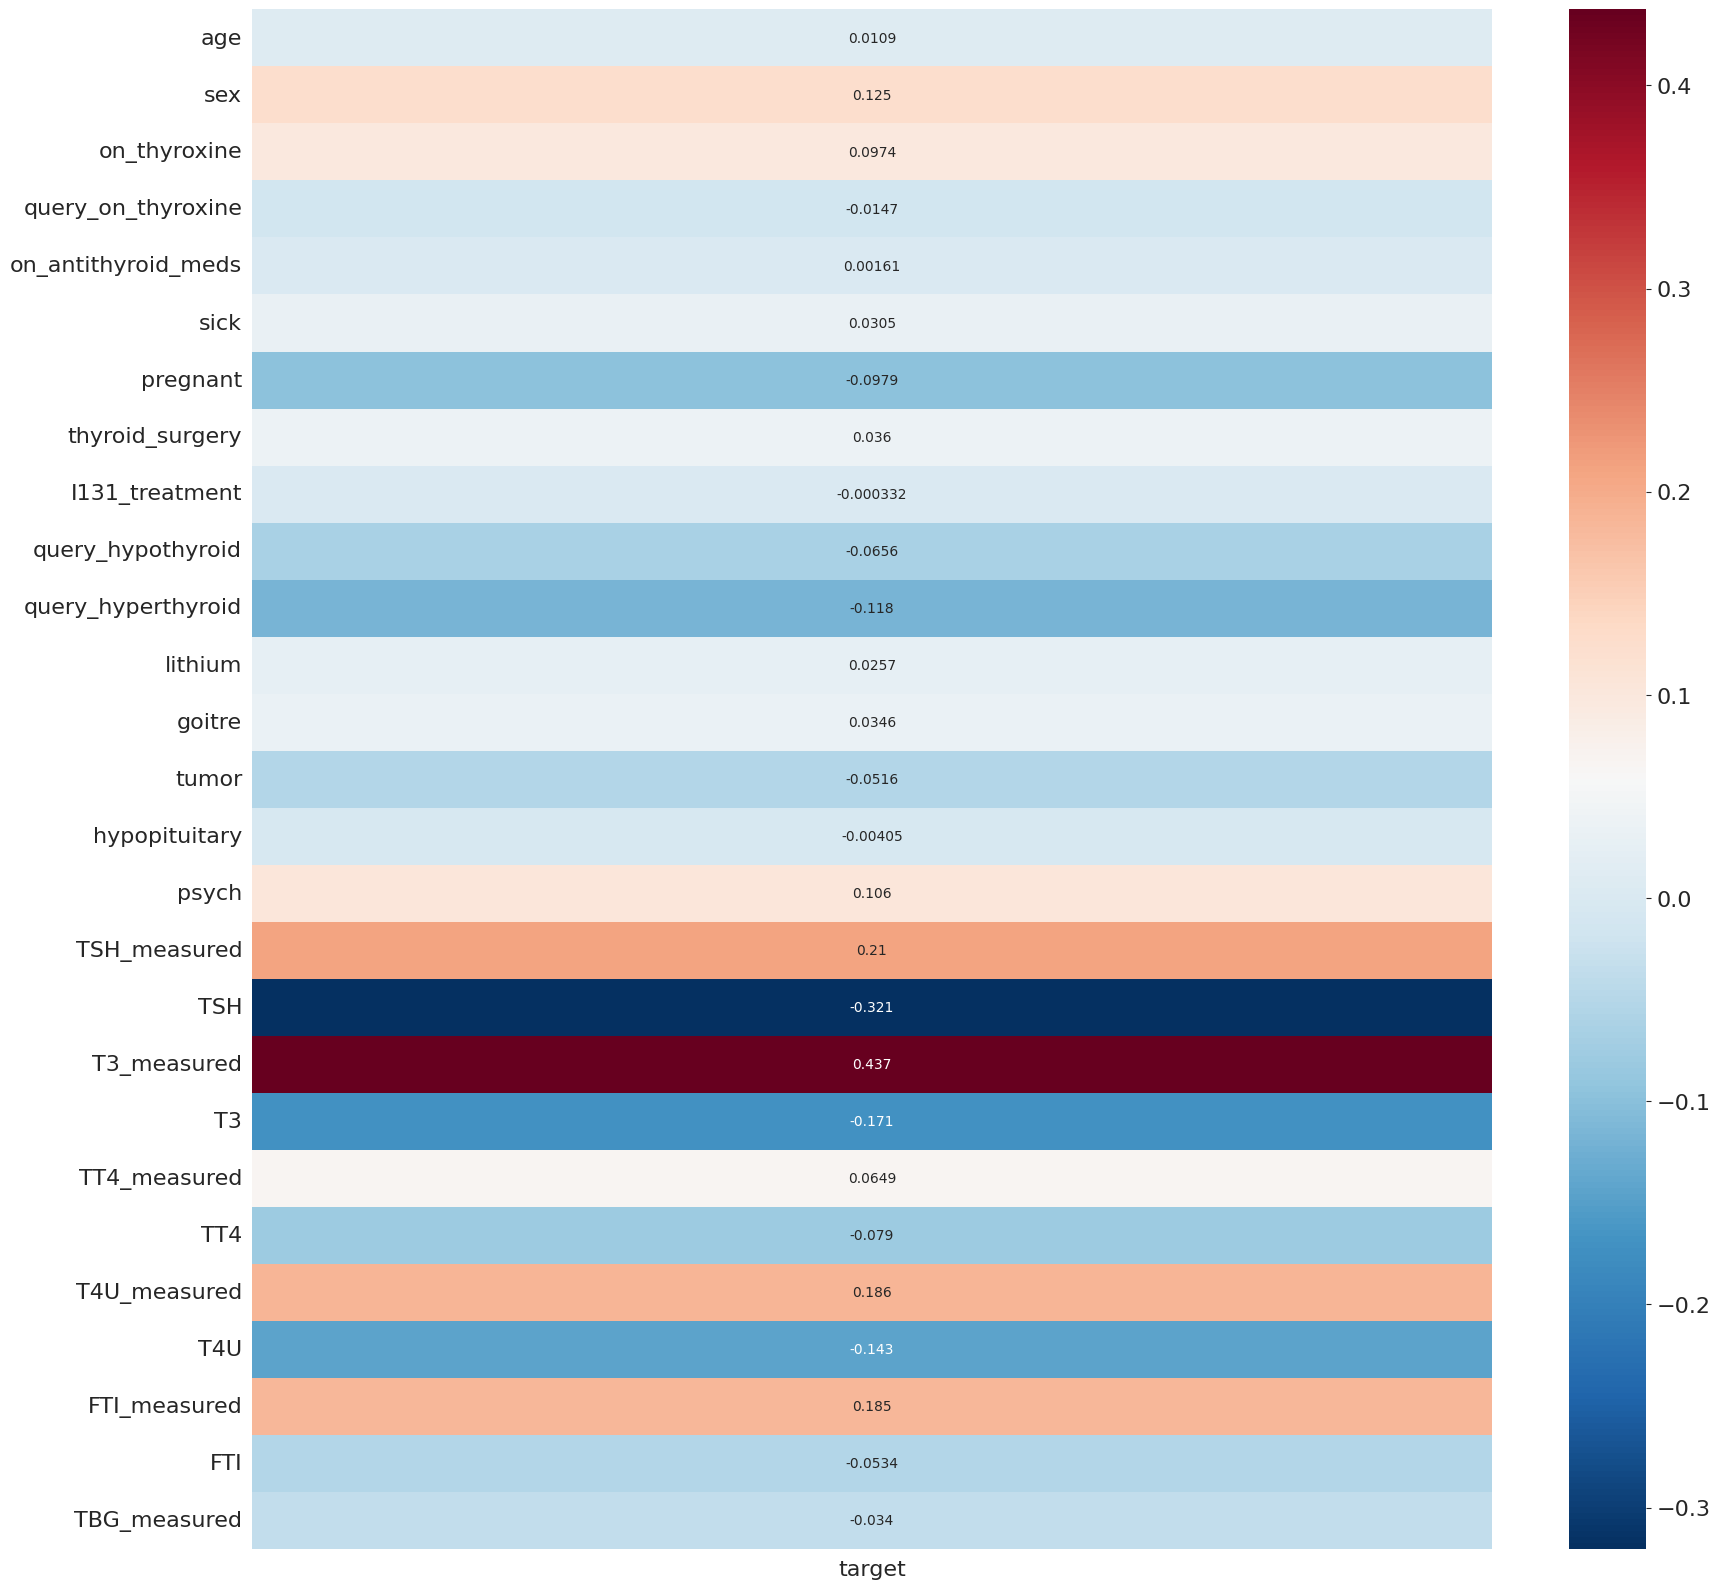

In [28]:
# Isolate the column corresponding to the target `NSP`
corr_target = correlation[['target']].drop(labels=['target'])

plt.figure(figsize=(20,20))
sns.heatmap(corr_target, annot=True, fmt='.3', cmap='RdBu_r')
plt.show()

In [29]:
result = corr_target[abs(corr_target)>0.2].dropna()
result

,target
TSH_measured,0.209888
TSH,-0.320523
T3_measured,0.437496


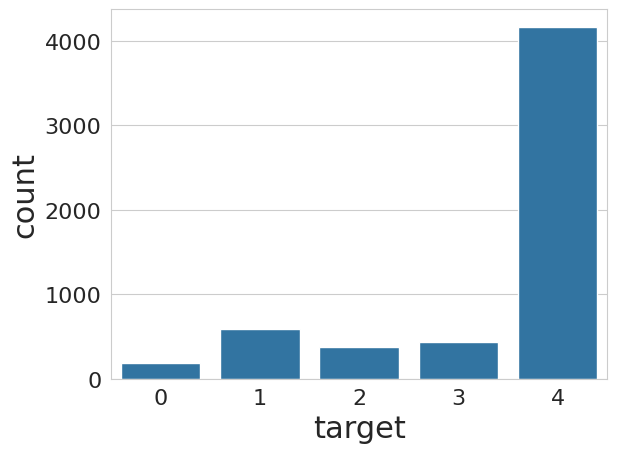

In [30]:
# data imbalance of target variable
sns.countplot(x ='target', data = thyroid_df)
plt.show()

In [31]:
percentage_ratio = {}
for target_value in sorted(thyroid_df['target'].unique()):
    ratio = (thyroid_df['target'] == target_value).mean() * 100
    percentage_ratio[target_value] = round(ratio)

print("Percentage ratio:", " : ".join(f"{ratio}%" for ratio in percentage_ratio.values()))


Percentage ratio: 3% : 10% : 7% : 8% : 72%


## Age

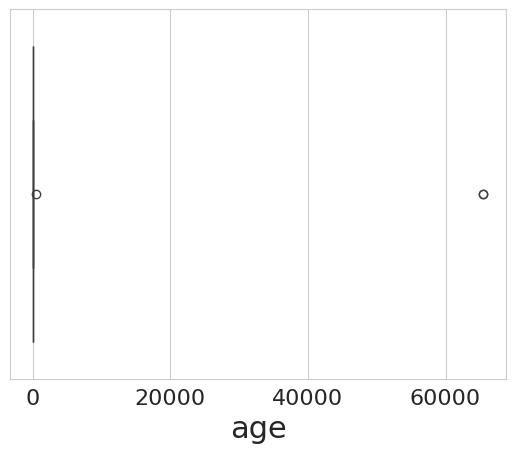

In [32]:
# general overview
sns.boxplot(x='age', data=thyroid_df)
plt.show()

In [33]:
#remove obvious outliers
#select rows where 'age' column is > 100
print(thyroid_df.loc[thyroid_df['age'] > 100])

#drop these values
thyroid_df.drop(thyroid_df[thyroid_df['age'] > 100].index, inplace = True)

# confirm shape
thyroid_df.shape

        age  sex  on_thyroxine  query_on_thyroxine  on_antithyroid_meds  sick  \
2976    455    0             0                   0                    0     0   
5710  65511    1             0                   0                    0     0   
6392  65512    1             0                   0                    0     0   

      pregnant  thyroid_surgery  I131_treatment  query_hypothyroid  ...  \
2976         0                0               0                  0  ...   
5710         0                0               0                  0  ...   
6392         0                0               0                  0  ...   

      T3_measured   T3  TT4_measured    TT4  T4U_measured   T4U  FTI_measured  \
2976            1  2.0             1  118.0             1  1.13             1   
5710            1  2.0             1  113.0             1  1.08             1   
6392            1  2.8             1  112.0             1  0.84             1   

        FTI  TBG_measured  target  
2976  104.0  

(5752, 28)

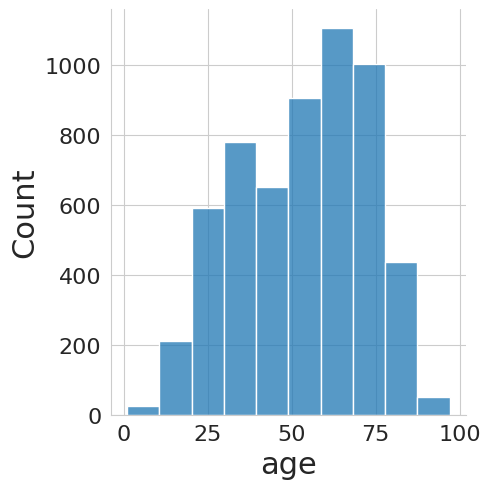

In [34]:
# Create a histogram of the age variable
sns.displot(thyroid_df.age, bins=10, kde=False)
plt.show()

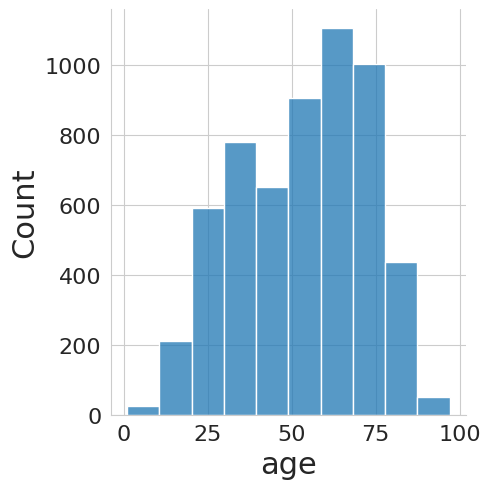

In [35]:
# Create a histogram of the age variable
sns.displot(thyroid_df.age, bins=10, kde=False)
plt.show()

## TSH

<ipython-input-36-b9e4b7c25904>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x = 'target', y = 'TSH', data = thyroid_df, palette='Accent')


<Axes: xlabel='target', ylabel='TSH'>

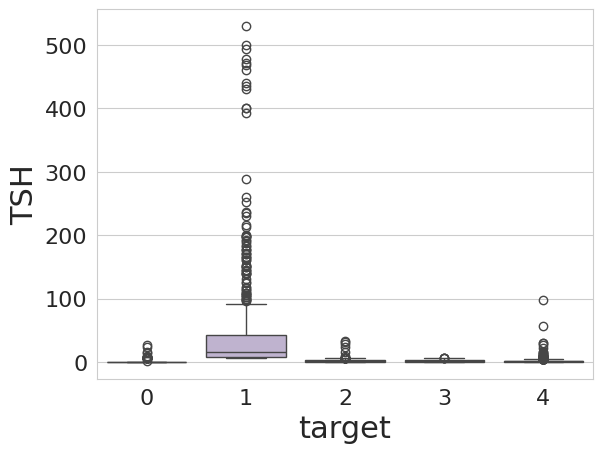

In [36]:
#vertical boxplot grouped by target class
sns.set_style("whitegrid")

sns.boxplot(x = 'target', y = 'TSH', data = thyroid_df, palette='Accent')

In [37]:
# checking average result according to target class
thyroid_df.groupby('target').TSH.mean()

target
0     1.784088
1    44.811486
2     2.111323
3     1.692576
4     1.604911
Name: TSH, dtype: float64

## T3

<ipython-input-38-cd250a9c41bd>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x = 'target', y = 'T3', data = thyroid_df, palette='Accent')


<Axes: xlabel='target', ylabel='T3'>

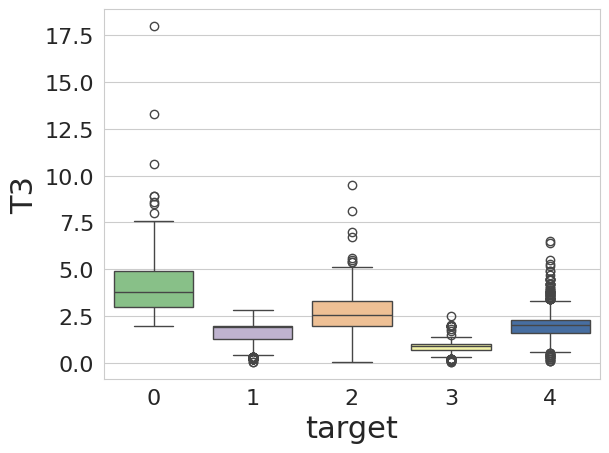

In [38]:
# vertical boxplot
sns.set_style("whitegrid")

sns.boxplot(x = 'target', y = 'T3', data = thyroid_df, palette='Accent')

In [39]:
#average result by target class
thyroid_df.groupby('target').T3.mean()

target
0    4.162664
1    1.592562
2    2.717515
3    0.859965
4    1.974896
Name: T3, dtype: float64

## TT4

<ipython-input-40-e3ee1486de89>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x = 'target', y = 'TT4', data = thyroid_df, palette='Accent')


<Axes: xlabel='target', ylabel='TT4'>

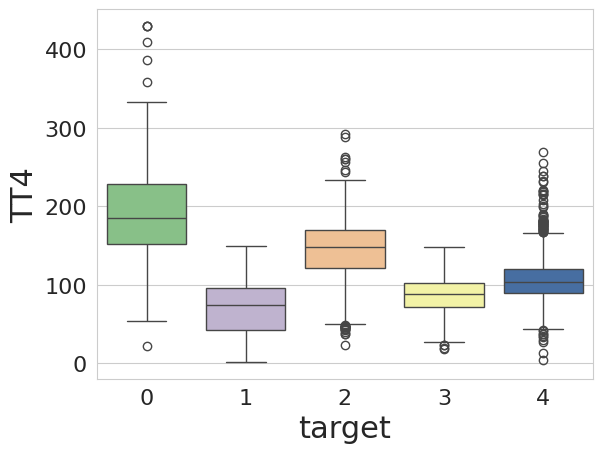

In [40]:
# vertical boxplot
sns.set_style("whitegrid")

sns.boxplot(x = 'target', y = 'TT4', data = thyroid_df, palette='Accent')

In [41]:
thyroid_df.groupby('target').TT4.mean()

target
0    193.780220
1     69.908788
2    145.196809
3     87.464705
4    106.183100
Name: TT4, dtype: float64

## GENDER

<Axes: xlabel='T3', ylabel='sex'>

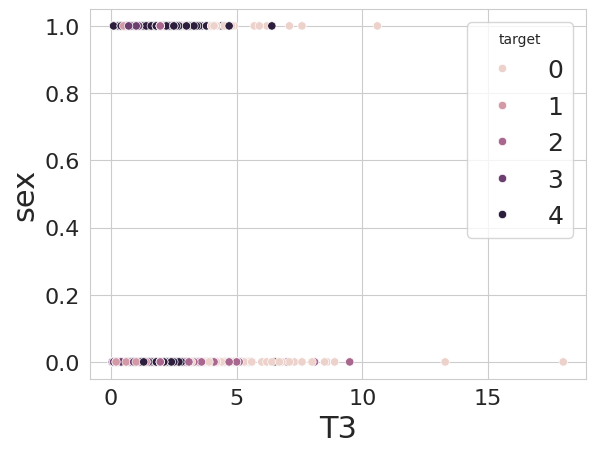

In [42]:
sns.scatterplot(x = "T3", y = "sex", data = thyroid_df, hue='target')

# FEATURE SELECTION

In [43]:
print(thyroid_df.shape)

#value count
thyroid_df.target.value_counts()

(5752, 28)


target
4    4165
1     593
3     436
2     376
0     182
Name: count, dtype: int64

## Undersampling

In [44]:
# randomly undersample target variable by 85.5%
thyroid_df = thyroid_df.drop(thyroid_df[thyroid_df['target'] == 4].sample(frac=0.855).index)

# shape of updated data
thyroid_df.shape

(2191, 28)

In [45]:
thyroid_df.target.value_counts()


target
4    604
1    593
3    436
2    376
0    182
Name: count, dtype: int64

## Feature importance

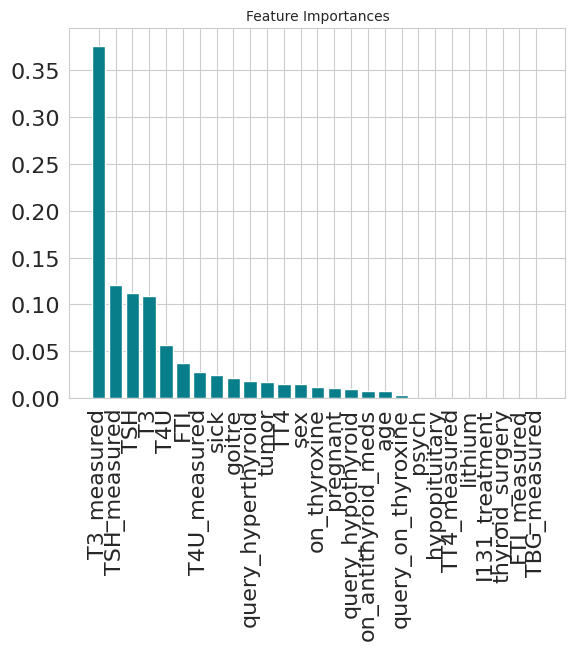

             Attribute  Importance
18         T3_measured    0.376009
16        TSH_measured    0.120396
17                 TSH    0.112017
19                  T3    0.108514
23                 T4U    0.056197
25                 FTI    0.037505
22        T4U_measured    0.027982
5                 sick    0.024496
12              goitre    0.021256
10  query_hyperthyroid    0.018112


In [46]:
# divide to dependent and independent
target_name = 'target'
y = thyroid_df[target_name]
x = thyroid_df.drop(target_name, axis=1)

# scaler fit
scaler = preprocessing.RobustScaler()
scaled_x = scaler.fit_transform(x)

# Split train and test
x_t, x_test, y_t, y_test = train_test_split(scaled_x, y, test_size=0.25, random_state=0)

# Model training for feature importance
model = XGBClassifier()
model.fit(x_t, y_t)

# Feature importance analysis
importances = pd.DataFrame(data={
    'Attribute': x.columns,
    'Importance': model.feature_importances_
})
importances = importances.sort_values(by='Importance', ascending=False)

# Visualization of feature importances
plt.bar(x=importances['Attribute'], height=importances['Importance'], color='#087E8B')
plt.title('Feature Importances', size=10)
plt.xticks(rotation='vertical')
plt.show()

# Select and print the top features by importance
top_features = importances.head(10)
print(top_features)

In [47]:
top_feature_names = top_features['Attribute'].tolist()

# Include the target column in the top features list
top_feature_names.append('target')

# Drop columns not in the top features list from the dataset
selected_data = thyroid_df[top_feature_names]

# Display the selected data
selected_data.head(5)

,T3_measured,TSH_measured,TSH,T3,T4U,FTI,T4U_measured,sick,goitre,query_hyperthyroid,target
18,0,1,68.00,1.95847,1.02,47.0,1,1,0,0,1
33,0,1,0.05,1.95847,1.38,91.0,1,0,0,0,2
41,1,1,1.90,2.10000,1.10,93.0,1,0,0,0,4
43,0,1,140.00,1.95847,1.07,31.0,1,0,0,0,1
48,1,1,0.40,1.30000,0.91,126.0,1,0,0,0,4


# ALGORITHM IMPLEMENTATION

In [97]:
# variable split
# divide to dependent and independent
target_name = 'target'
y = selected_data[target_name]
x = selected_data.drop(target_name, axis=1)

# Scaling data
scaler = preprocessing.RobustScaler()
scaled_x = scaler.fit_transform(x)

# split data into training and testing sets
x_t, x_test, y_t, y_test = train_test_split(scaled_x, y, test_size=0.25, random_state=0)

# oversample technique on train dataset only

sm = SMOTE(random_state=42)
x_train, y_train = sm.fit_resample(x_t, y_t)

# shape before and after oversampling applied
x_t.shape, y_t.shape, x_train.shape, y_train.shape

((1643, 10), (1643,), (2310, 10), (2310,))

## Machine learning model training

In [98]:
def evaluate_classifier(classifier, x_train, y_train, x_test, y_test):
    classifier.fit(x_train, y_train)
    prediction = classifier.predict(x_test)
    report = classification_report(y_test, prediction, output_dict=True)
    report_df = pd.DataFrame(report).transpose()
    return report_df[['precision', 'recall', 'f1-score']]

# Train and evaluate RandomForestClassifier
report_rf = evaluate_classifier(RandomForestClassifier(), x_train, y_train, x_test, y_test)

# Train and evaluate XGBClassifier
report_xgb = evaluate_classifier(XGBClassifier(), x_train, y_train, x_test, y_test)

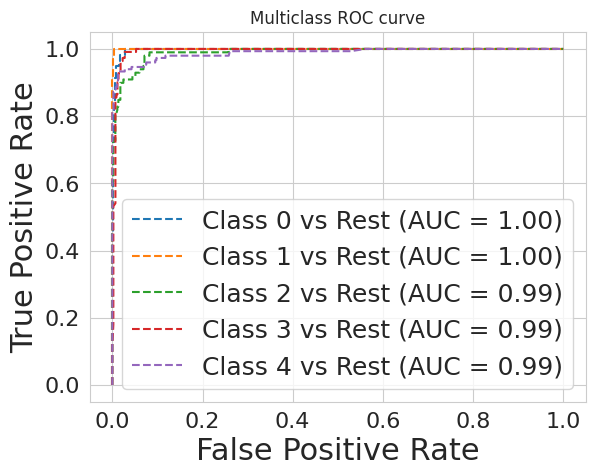

In [99]:
def plot_multiclass_roc(clf, x_train, y_train, x_test, y_test):
    clf.fit(x_train, y_train)
    pred_prob = clf.predict_proba(x_test)

    n_classes = len(clf.classes_)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test == i, pred_prob[:, i])
        roc_auc[i] = roc_auc_score(y_test == i, pred_prob[:, i])
        plt.plot(fpr[i], tpr[i], linestyle='--', label=f'Class {i} vs Rest (AUC = {roc_auc[i]:.2f})')

    plt.title('Multiclass ROC curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='best')
    plt.show()

# Usage
rf_clf = OneVsRestClassifier(RandomForestClassifier())
plot_multiclass_roc(rf_clf, x_train, y_train, x_test, y_test)

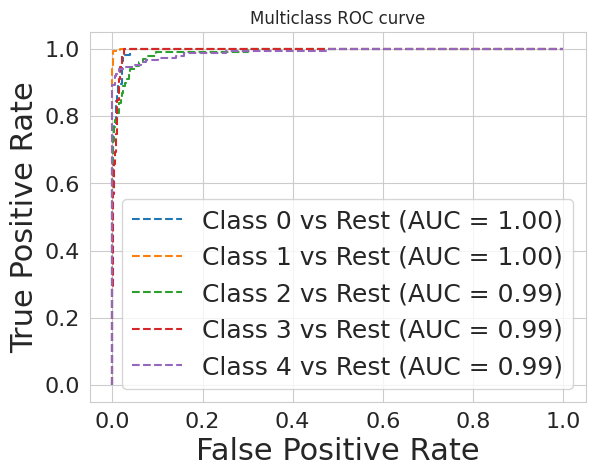

In [100]:
xgb_clf = OneVsRestClassifier(XGBClassifier())
plot_multiclass_roc(xgb_clf, x_train, y_train, x_test, y_test)

## Deep learning- CNN training

In [102]:
# Convert data to numpy arrays
x_train, x_test, y_train, y_test = map(np.array, [x_train, x_test, y_train, y_test])

# CNN Initialization
model = Sequential([
    Conv1D(128, 5, activation="relu", input_shape=(10,1)),
    Conv1D(64, 5, activation="relu"),
    Dropout(0.1),
    Flatten(),
    Dense(5, activation="softmax")
])
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

# Fitting the model
history = model.fit(x_train, y_train, batch_size=16, epochs=150, verbose=1, validation_split=0.25)

# Predictions
yhat_probs = model.predict(x_test, verbose=0)
y_pred = np.argmax(yhat_probs, axis=1)
yhat_probs = yhat_probs[:, 0]

# Classification report
report = classification_report(y_test, y_pred, output_dict=True)
report_cnn = pd.DataFrame(report).transpose().drop('support', axis=1)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_8 (Conv1D)           (None, 6, 128)            768       
                                                                 
 conv1d_9 (Conv1D)           (None, 2, 64)             41024     
                                                                 
 dropout_4 (Dropout)         (None, 2, 64)             0         
                                                                 
 flatten_3 (Flatten)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 5)                 645       
                                                                 
Total params: 42437 (165.77 KB)
Trainable params: 42437 (165.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/150
109/

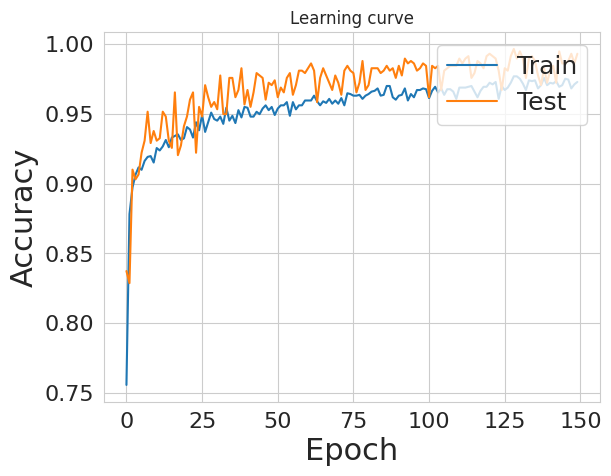

In [104]:
# accuracy graph

plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Test')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.title('Learning curve')
plt.legend(loc='upper right')

## Evaluation

In [103]:
# Calculate average report for each classifier
average_report_rf = report_rf.mean()
average_report_xgb = report_xgb.mean()
average_report_cnn = report_cnn.mean()


# Combine the average reports into a single DataFrame
average_reports = pd.concat([average_report_rf, average_report_xgb, average_report_cnn], axis=0,
                            keys=['RandomForestClassifier', 'XGBClassifier', 'CNNClassifier'])

# Display the combined DataFrame
print("Combined Average Classification Reports:")
average_reports

Combined Average Classification Reports:


RandomForestClassifier  precision    0.930705
                        recall       0.938111
                        f1-score     0.933865
XGBClassifier           precision    0.926281
                        recall       0.925480
                        f1-score     0.925706
CNNClassifier           precision    0.926649
                        recall       0.921672
                        f1-score     0.923710
dtype: float64

In [105]:
# Classification report results
classification_results = {
    'Classifier': ['RandomForestClassifier', 'RandomForestClassifier', 'RandomForestClassifier',
                   'XGBClassifier', 'XGBClassifier', 'XGBClassifier',
                   'CNNClassifier', 'CNNClassifier', 'CNNClassifier'],
    'Metric': ['precision', 'recall', 'f1-score',
               'precision', 'recall', 'f1-score',
               'precision', 'recall', 'f1-score'],
    'Score': [0.930705, 0.938111, 0.933865,
              0.926281, 0.925480, 0.925706,
              0.926649, 0.921672, 0.923710]
}

# Create DataFrame
df_classification_results = pd.DataFrame(classification_results)

# Save DataFrame to CSV
df_classification_results.to_csv('classification_results.csv', index=False)


In [106]:
df_classification_results

,Classifier,Metric,Score
0,RandomForestClassifier,precision,0.930705
1,RandomForestClassifier,recall,0.938111
2,RandomForestClassifier,f1-score,0.933865
3,XGBClassifier,precision,0.926281
4,XGBClassifier,recall,0.925480
5,XGBClassifier,f1-score,0.925706
6,CNNClassifier,precision,0.926649
7,CNNClassifier,recall,0.921672
8,CNNClassifier,f1-score,0.923710
